# Train Machine Learning Models (LR, XGB)
## Load dataset

In [ ]:
import pandas as pd

df = pd.read_csv('../../data/vivli_data_final(in).csv')

# print(df.head(5))
# print(df.columns)

## Data check
### Check resistance rates

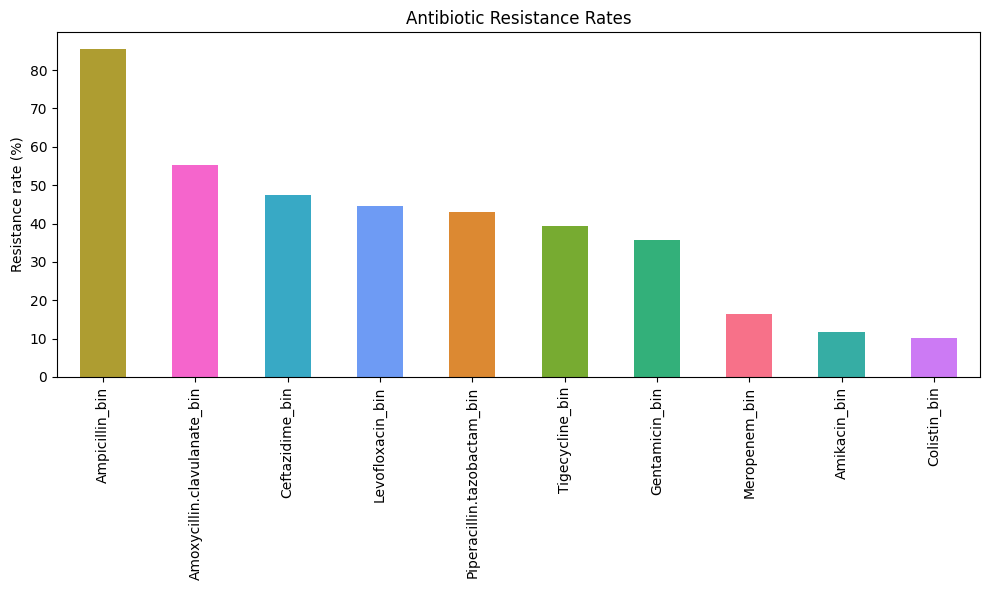

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify antibiotic columns: numeric columns minus obvious metadata
drug_cols = [
    'Meropenem_bin',
    'Piperacillin.tazobactam_bin', 'Ampicillin_bin', 'Tigecycline_bin',
    'Gentamicin_bin', 'Amikacin_bin', 'Ceftazidime_bin', 'Levofloxacin_bin',
    'Colistin_bin', 'Amoxycillin.clavulanate_bin'
]

# More exhaustive list of antibiotics
# drug_cols = [
#     'Piperacillin.tazobactam', 'Amikacin', 'Amoxycillin.clavulanate',
#     'Ampicillin', 'Cefepime', 'Ceftazidime', 'Imipenem', 'Levofloxacin',
#     'Linezolid', 'Meropenem', 'Penicillin', 'Tigecycline',
#     'Ampicillin.sulbactam', 'Aztreonam', 'Ceftaroline',
#     'Ceftazidime.avibactam', 'Ciprofloxacin', 'Colistin', 'Gentamicin'
# ]

palette = sns.color_palette("husl", len(drug_cols))   # 13 distinct hues
colour_map = {drug: palette[i] for i, drug in enumerate(drug_cols)}

# Calculate resistance rate (percentage of 1s)
resistance_rates = df[drug_cols].mean() * 100
resistance_rates = resistance_rates.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
resistance_rates.plot(kind="bar", color=[colour_map[drug] for drug in resistance_rates.index])
plt.ylabel("Resistance rate (%)")
plt.title("Antibiotic Resistance Rates")
plt.tight_layout()
plt.show()

## Modeling & Evaluation (single condition)

This section trains multi-output classification models to predict antibiotic resistance for multiple drugs.
Key points and workflow:

- Preprocessing: one-hot encode categorical features (`gender`, `country`) and standardize numeric features (`icu`, `age`, `year`, plus an optional conditioning drug).
- Models: Logistic Regression (one-vs-rest via `MultiOutputClassifier`) and XGBoost (one-vs-rest). Both pipelines live in the notebook and are trained on the 2018–2022 data, with 2023 held out for testing.
- Conditioning drug: set `condition_drug` (in the Python cell below) to a specific drug name to include that drug's resistance as an input feature, or `None` to omit it.
- Tuning: grid search / cross-validation is available (controlled by `use_grid` in the GridSearch section) — note this increases runtime substantially.
- Outputs saved: per-model ROC/PR plots (`roc_*.png`, `pr_*.png`), micro-averaged ROC (`roc_micro_avg.png`), grid-of-ROCs (`grid_roc_*.png`), per-target confusion matrices (`cm_*.png`), and AUC/metric heatmaps (`heatmap_*.png`).
- Notes:
    - The notebook splits by calendar year (train = 2018–2022, test = 2023) to simulate temporal generalization.
    - Some targets may be degenerate in the test set (single class); those are skipped for ROC/AUC and some metrics.
    - Adjust hyperparameters (e.g. `n_estimators`, `max_depth`) and class-weighting to handle class imbalance as needed.

/var/folders/qx/2xhr1gk12_sfcqrn8db9ngh40000gn/T/ipykernel_27154/484519324.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['age'] = df['age'].replace({'65 and Over': 1, '19 to 64 Years': 0})



Test-year (2023) metrics
                         target    model  balanced_accuracy   roc_auc
10                 Amikacin_bin   LogReg           0.648263  0.698780
11                 Amikacin_bin  XGBoost           0.521244  0.706340
18  Amoxycillin.clavulanate_bin   LogReg           0.585205  0.653052
19  Amoxycillin.clavulanate_bin  XGBoost           0.591536  0.649073
4                Ampicillin_bin   LogReg           0.563727  0.590515
5                Ampicillin_bin  XGBoost           0.500000  0.592940
12              Ceftazidime_bin   LogReg           0.604705  0.652899
13              Ceftazidime_bin  XGBoost           0.589661  0.643493
16                 Colistin_bin   LogReg           0.548054  0.581671
17                 Colistin_bin  XGBoost           0.500000  0.578224
8                Gentamicin_bin   LogReg           0.625546  0.668106
9                Gentamicin_bin  XGBoost           0.567272  0.658802
14             Levofloxacin_bin   LogReg           0.582183  0.6

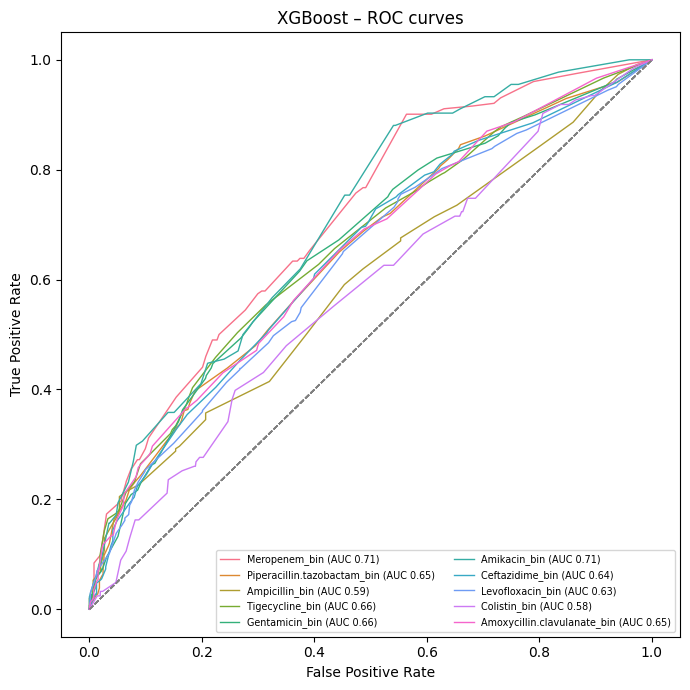

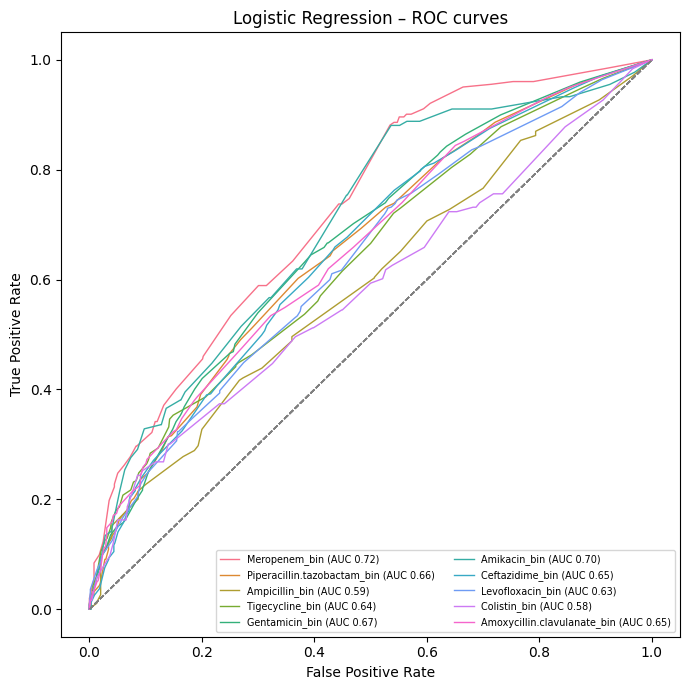

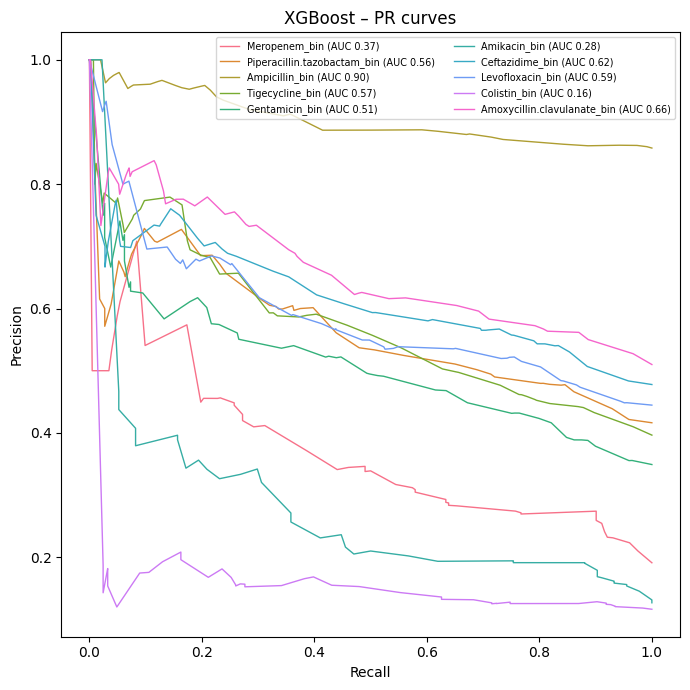

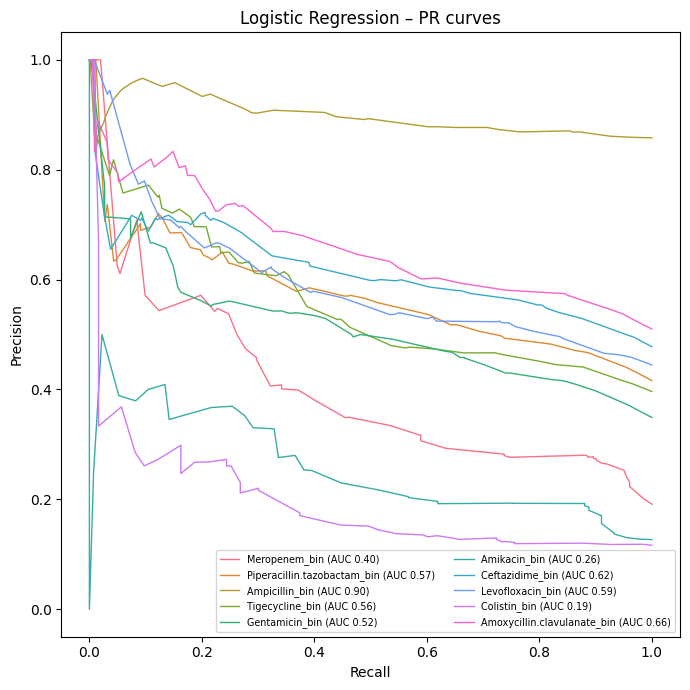

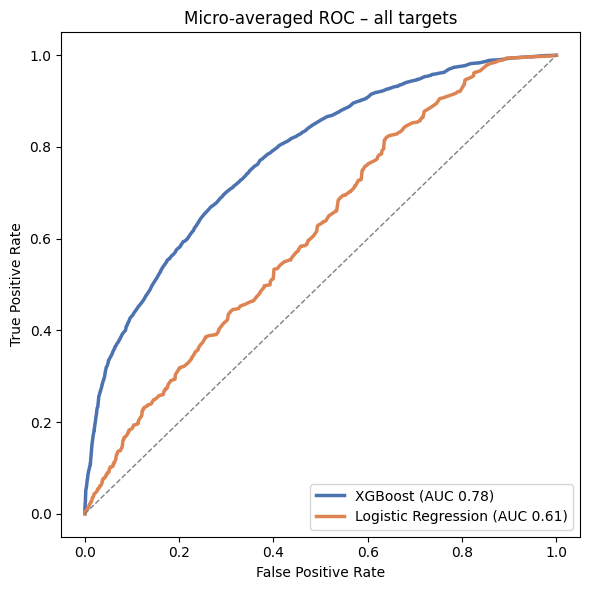


=== LogReg classification report (2023) ===
                             precision    recall  f1-score   support

              Meropenem_bin       0.28      0.74      0.41       202
Piperacillin.tazobactam_bin       0.54      0.60      0.57       440
             Ampicillin_bin       0.91      0.33      0.48       907
            Tigecycline_bin       0.47      0.72      0.57       419
             Gentamicin_bin       0.47      0.64      0.54       369
               Amikacin_bin       0.19      0.75      0.31       134
            Ceftazidime_bin       0.60      0.54      0.57       505
           Levofloxacin_bin       0.54      0.53      0.54       470
               Colistin_bin       0.14      0.54      0.22       123
Amoxycillin.clavulanate_bin       0.73      0.27      0.40       539

                  micro avg       0.45      0.51      0.48      4108
                  macro avg       0.49      0.57      0.46      4108
               weighted avg       0.60      0.51      0.

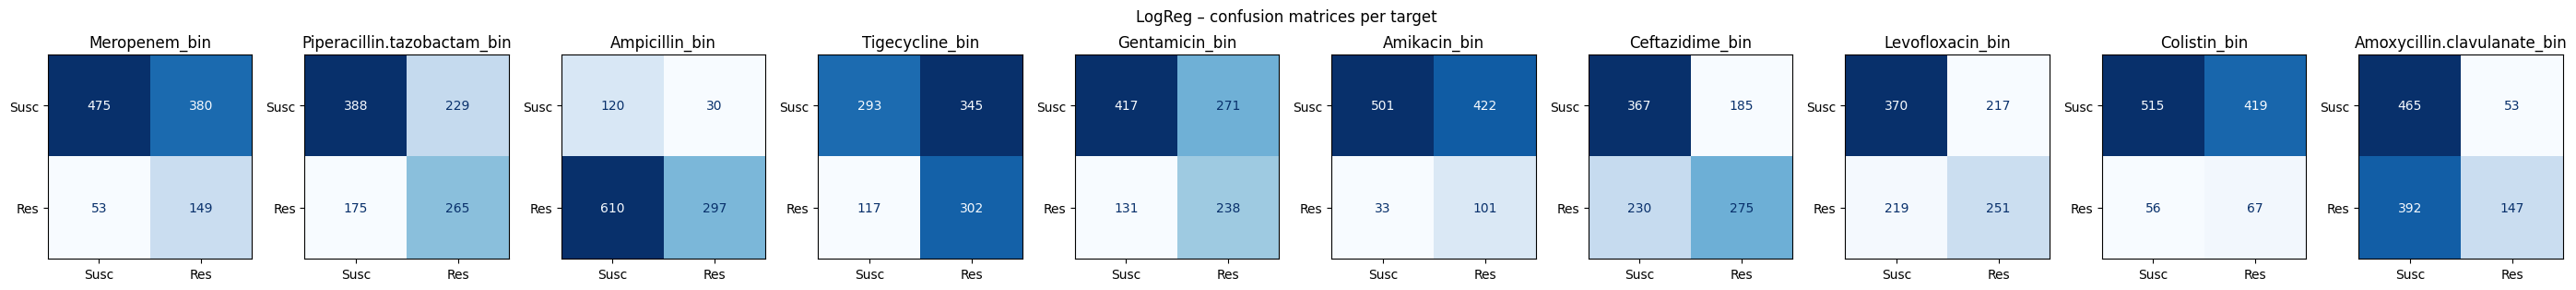


=== XGBoost classification report (2023) ===
                             precision    recall  f1-score   support

              Meropenem_bin       0.59      0.05      0.09       202
Piperacillin.tazobactam_bin       0.61      0.32      0.42       440
             Ampicillin_bin       0.86      1.00      0.92       907
            Tigecycline_bin       0.59      0.33      0.43       419
             Gentamicin_bin       0.60      0.21      0.31       369
               Amikacin_bin       0.44      0.05      0.09       134
            Ceftazidime_bin       0.62      0.40      0.49       505
           Levofloxacin_bin       0.59      0.36      0.45       470
               Colistin_bin       0.00      0.00      0.00       123
Amoxycillin.clavulanate_bin       0.63      0.48      0.55       539

                  micro avg       0.70      0.47      0.56      4108
                  macro avg       0.55      0.32      0.37      4108
               weighted avg       0.64      0.47      0

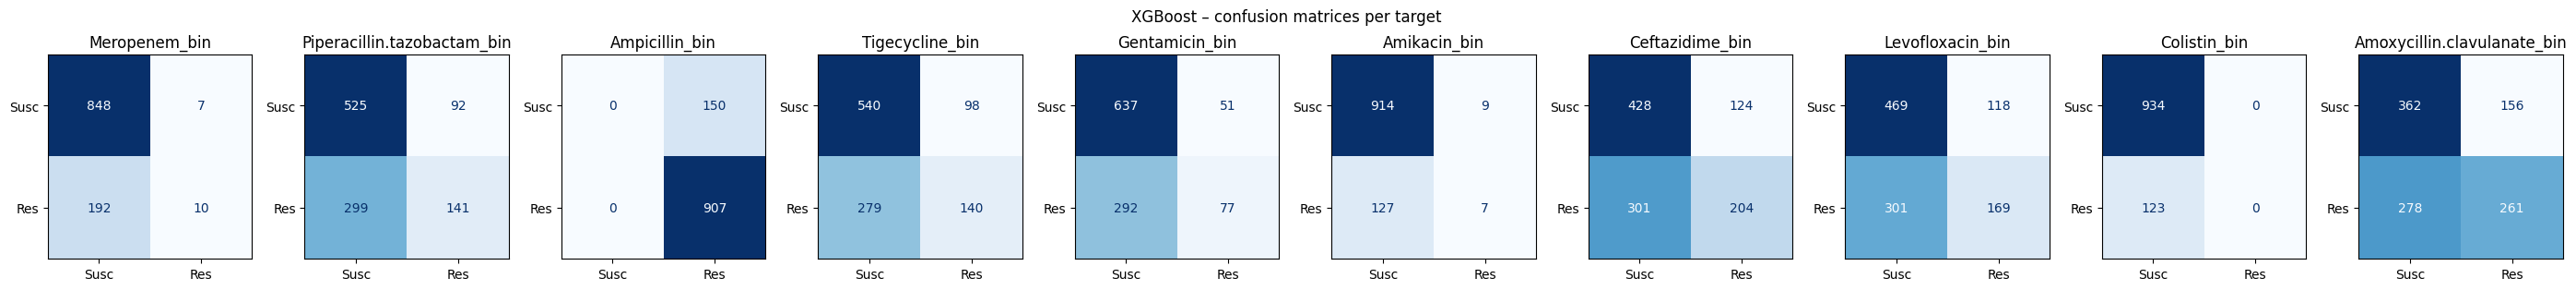

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier


#  Choose one drug to condition on (include as a feature); or None to use only demographics + ICU
condition_drug = None 
# condition_drug = "Piperacillin.tazobactam"

###############################################
# 1. Data preparation
###############################################

# Binarise age: 1 if age = '65 and Over', 0 if age = '19 to 64 Years'
df['age'] = df['age'].replace({'65 and Over': 1, '19 to 64 Years': 0})

# Define features and targets
target_cols = [c for c in drug_cols if c != condition_drug]

categorical = ["gender", "country"] # "age"

if condition_drug:
    numeric     = ["icu", "age", "year"] + [condition_drug] # TODO test dropping "year"
else:
    numeric     = ["icu", "age", "year"]

###############################################
# 2. Train/test with temporal split
###############################################
train_df = df[df["year"].between(2018, 2022)]
test_df  = df[df["year"] == 2023]

X_train, y_train = train_df[categorical + numeric], train_df[target_cols]
X_test,  y_test  = test_df[categorical + numeric],  test_df[target_cols]

###############################################
# 3. Pre-processing
###############################################
preproc = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric),
    ]
)

###############################################
# 4-A. Logistic-regression models (one-vs-rest)
###############################################
logreg_base = LogisticRegression(
    penalty="l2",
    class_weight="balanced",
    max_iter=1000,
    solver="saga"
)

logreg_pipeline = Pipeline(steps=[
    ("prep", preproc),
    ("clf",  MultiOutputClassifier(logreg_base, n_jobs=-1))
])

logreg_pipeline.fit(X_train, y_train)

###############################################
# 4-B. XGBoost models (one-vs-rest)
###############################################
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    scale_pos_weight=1
)

xgb_pipeline = Pipeline(steps=[
    ("prep", preproc),
    ("clf",  MultiOutputClassifier(xgb_base, n_jobs=-1))
])

xgb_pipeline.fit(X_train, y_train)

###############################################
# 5. Evaluation
###############################################
def evaluate(model, X, y, label):
    y_pred   = model.predict(X)
    y_proba  = model.predict_proba(X)   # list of arrays
    bac = balanced_accuracy_score(y[label], y_pred[:, target_cols.index(label)])
    try:
        auc = roc_auc_score(y[label], y_proba[target_cols.index(label)][:,1])
    except ValueError:
        auc = np.nan   # AUC undefined if only one class present
    return bac, auc

metrics = {"target":[], "model":[], "balanced_accuracy":[], "roc_auc":[]}

for tgt in target_cols:
    bac, auc = evaluate(logreg_pipeline, X_test, y_test, tgt)
    metrics["target"].append(tgt); metrics["model"].append("LogReg")
    metrics["balanced_accuracy"].append(bac); metrics["roc_auc"].append(auc)

    bac, auc = evaluate(xgb_pipeline, X_test, y_test, tgt)
    metrics["target"].append(tgt); metrics["model"].append("XGBoost")
    metrics["balanced_accuracy"].append(bac); metrics["roc_auc"].append(auc)

metrics_df = pd.DataFrame(metrics).sort_values(["target","model"])
print("\nTest-year (2023) metrics")
print(metrics_df)

###############################################
# 7. Visual evaluation – ROC, PR, confusion matrix
###############################################

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# ---------------------------------------------------------------------------
# 7-A.  Pick one nice qualitative palette and lock the colour → drug mapping
# ---------------------------------------------------------------------------
palette = sns.color_palette("husl", len(target_cols))          # or "tab10", "Set2", etc.
colour_map = {drug: palette[i] for i, drug in enumerate(target_cols)}

# ---------------------------------------------------------------------------
# 7-B.  Generic helper:  draw *either* ROC or PR for one model
# ---------------------------------------------------------------------------
def plot_metric_curves(
    model, X, y_true, metric="roc", title_prefix="", save_as="tmp.png", lw=2
):
    """
    metric: "roc" or "pr"
    """
    plt.figure(figsize=(7, 7))
    for i, drug in enumerate(target_cols):
        y_score = model.predict_proba(X)[i][:, 1]
        y_bin   = y_true[drug].values
        if len(np.unique(y_bin)) == 1:                 # skip degenerate curves
            continue

        if metric == "roc":
            fpr, tpr, _ = roc_curve(y_bin, y_score)
            curve_auc   = auc(fpr, tpr)
            plt.plot(
                fpr,
                tpr,
                lw=lw,
                color=colour_map[drug],
                label=f"{drug} (AUC {curve_auc:.2f})",
            )
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.plot([0, 1], [0, 1], "--", color="grey", lw=1)
        else:  # PR curve
            pr, rc, _   = precision_recall_curve(y_bin, y_score)
            curve_auc   = auc(rc, pr)
            plt.plot(
                rc,
                pr,
                lw=lw,
                color=colour_map[drug],
                label=f"{drug} (AUC {curve_auc:.2f})",
            )
            plt.xlabel("Recall")
            plt.ylabel("Precision")

    plt.title(f"{title_prefix} – {'ROC' if metric=='roc' else 'PR'} curves")
    plt.legend(fontsize="x-small", ncol=2, frameon=True)
    plt.tight_layout()
    plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()

# ---------------------------------------------------------------------------
# 7-C.  Create the requested plots
# ---------------------------------------------------------------------------
# ROC – XGBoost only
plot_metric_curves(
    xgb_pipeline,
    X_test,
    y_test,
    metric="roc",
    title_prefix="XGBoost",
    save_as="roc_xgb.png",
    lw=1,
)

# ROC – Logistic regression only
plot_metric_curves(
    logreg_pipeline,
    X_test,
    y_test,
    metric="roc",
    title_prefix="Logistic Regression",
    save_as="roc_logreg.png",
    lw=1,
)

# PR – XGBoost only
plot_metric_curves(
    xgb_pipeline,
    X_test,
    y_test,
    metric="pr",
    title_prefix="XGBoost",
    save_as="pr_xgb.png",
    lw=1,
)

# PR – Logistic regression only
plot_metric_curves(
    logreg_pipeline,
    X_test,
    y_test,
    metric="pr",
    title_prefix="Logistic Regression",
    save_as="pr_logreg.png",
    lw=1,
)

##############################################################################
# 7-D.  (Optional) micro-average ROC for a quick global snapshot
##############################################################################
def plot_micro_avg(model, X, y_true, name="", c="#333333", lw=2.5):
    y_score = np.hstack([p[:, 1][:, None] for p in model.predict_proba(X)])
    fpr, tpr, _ = roc_curve(y_true[target_cols].values.ravel(), y_score.ravel())
    plt.plot(fpr, tpr, lw=lw, label=f"{name} (AUC {auc(fpr, tpr):.2f})", color=c)

plt.figure(figsize=(6, 6))
plot_micro_avg(xgb_pipeline,   X_test, y_test, name="XGBoost",            c="#4c72b0")
plot_micro_avg(logreg_pipeline, X_test, y_test, name="Logistic Regression", c="#dd8452")
plt.plot([0, 1], [0, 1], "--", lw=1, color="grey")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Micro-averaged ROC – all targets")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_micro_avg.png", dpi=300, bbox_inches="tight")
plt.show()


############################################################
# 7-E. Confusion matrix & classification report
############################################################
for mdl_name, mdl in [("LogReg", logreg_pipeline), ("XGBoost", xgb_pipeline)]:
    print(f"\n=== {mdl_name} classification report (2023) ===")
    y_pred = pd.DataFrame(mdl.predict(X_test), columns=target_cols, index=y_test.index)
    print(classification_report(y_test, y_pred, zero_division=0, target_names=target_cols))

    # heatmap grid (targets × targets) showing counts of TP, FP, FN, TN per label
    fig, axes = plt.subplots(1, len(target_cols), figsize=(2.8 * len(target_cols), 3))
    if len(target_cols) == 1:   # single target => axes is not a list
        axes = [axes]

    for ax, lbl in zip(axes, target_cols):
        cm = confusion_matrix(y_test[lbl], y_pred[lbl])
        disp = ConfusionMatrixDisplay(cm, display_labels=["Susc", "Res"])
        disp.plot(ax=ax, colorbar=False, cmap="Blues", values_format="d")
        ax.set_title(lbl)
        ax.set_xlabel(""); ax.set_ylabel("")
    fig.suptitle(f"{mdl_name} – confusion matrices per target")
    plt.tight_layout()
    plt.savefig(f"cm_{mdl_name}.png", dpi=300, bbox_inches="tight")
    plt.show()


## Modeling & Evaluation (grid)

In [ ]:
##############################################################################
# 7.  ROC grids: one big grid per model, loop over conditioning drugs ########
##############################################################################
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from math import ceil, sqrt
import numpy as np 

# ---------------------------------------------------------------------------
# 7-A.  Prepare:  global colour map (stable across all subplots)
# ---------------------------------------------------------------------------
palette = sns.color_palette("husl", len(drug_cols))   # 13 distinct hues
colour_map = {drug: palette[i] for i, drug in enumerate(drug_cols)}

##############################################################################
# 7‑B.  Helper:  train model, **tune it with GridSearchCV**, collect ROC curves
##############################################################################
from sklearn.model_selection import GridSearchCV, KFold   # NEW
from sklearn.metrics import make_scorer, roc_auc_score    # NEW

def _mean_roc_auc_ovr(y_true, y_pred_prob):
    """Average one‑vs‑rest ROC‑AUC across all outputs (works with multilabel)"""
    return roc_auc_score(y_true, y_pred_prob, average="macro")

roc_auc_ovr = make_scorer(_mean_roc_auc_ovr, needs_proba=True)

def train_and_curves(
    cond_drug,
    model_type="xgb",
    use_grid=True,          # NEW – switch tuning on/off
    cv_splits=3,            # NEW – k‑fold for the search
):
    """
    cond_drug: None or one of drug_cols
    model_type: "xgb" or "lr"
    Returns dict(label -> (fpr, tpr, AUC))
    """
    numeric = ["icu", "year", "age"] + ([cond_drug] if cond_drug else [])
    targets = [d for d in drug_cols if d != cond_drug]

    preproc = ColumnTransformer(
        [("cat", OneHotEncoder(handle_unknown="ignore"), ["gender", "country"]),
         ("num", StandardScaler(), numeric)]
    )

    # ---- 1.  Base estimator definitions -----------------------------------
    if model_type == "xgb":
        base = XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            n_jobs=-1,
            use_label_encoder=False,          # suppress warning (≥1.7)
        )
        param_grid = {
            "clf__estimator__n_estimators":  [200, 400, 600],
            "clf__estimator__max_depth":     [3, 4, 5],
            "clf__estimator__learning_rate": [0.01, 0.05, 0.1],
            "clf__estimator__subsample":     [0.8, 1.0],
            "clf__estimator__colsample_bytree": [0.8, 1.0],
        }
    else:  # logistic regression
        base = LogisticRegression(
            class_weight="balanced",
            solver="saga",
            max_iter=2000,
        )
        param_grid = {
            "clf__estimator__penalty": ["l1", "l2"],
            "clf__estimator__C":       [0.1, 1, 10],
            # saga supports both l1 & l2
        }

    pipe = Pipeline(
        [("prep", preproc),
         ("clf", MultiOutputClassifier(base, n_jobs=-1))]
    )

    # ---- 2.  Optional GridSearchCV -----------------------------------------
    estimator = pipe
    if use_grid:
        cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
        estimator = GridSearchCV(
            pipe,
            param_grid,
            scoring=roc_auc_ovr,
            cv=cv,
            n_jobs=-1,
            refit=True,
            verbose=1,
        )

    # ---- 3.  Fit & predict --------------------------------------------------
    X_train = train_df[["gender", "country"] + numeric]
    y_train = train_df[targets]
    estimator.fit(X_train, y_train)

    X_test = test_df[["gender", "country"] + numeric]
    probas  = estimator.predict_proba(X_test)

    # ---- 4.  Collect ROC curves --------------------------------------------
    curves = {}
    for i, tgt in enumerate(targets):
        y_true = test_df[tgt].values
        if len(np.unique(y_true)) < 2:      # ROC undefined if only one class
            continue
        fpr, tpr, _ = roc_curve(y_true, probas[i][:, 1])
        curves[tgt] = (fpr, tpr, auc(fpr, tpr))

    # ★ Optional: keep best params for inspection
    if use_grid:
        print(
            f"[{model_type.upper()} | {cond_drug or 'None'}] "
            f"best ROC‑AUC={estimator.best_score_:.3f} with {estimator.best_params_}"
        )

    return curves, targets


# ---------------------------------------------------------------------------
# 7-C.  Build ROC-curve store for **every** conditioning choice
# ---------------------------------------------------------------------------
conditioning_choices = [None] + drug_cols            # 14 panels
roc_store_xgb = {}
roc_store_lr  = {}
targets_store = {}                                   # keep per-panel target list

for cd in conditioning_choices:
    roc_store_xgb[cd], targets_store[cd] = train_and_curves(cd, "xgb")
    roc_store_lr[cd],  _                  = train_and_curves(cd, "lr")

# ---------------------------------------------------------------------------
# 7‑D.  Function to draw one grid (one model) – now with per‑panel mean curve
# ---------------------------------------------------------------------------
def plot_grid_with_auc(
    roc_dict,
    model_name,
    line_style,
    save_as,
    average_colour="black",
    average_label="Average",
):
    """
    roc_dict   = {conditioning_drug -> {target -> (fpr, tpr, AUC)}}
    model_name = title string
    line_style = "-" (solid) or "--" (dashed)
    """
    n = len(conditioning_choices)
    ncols = 4
    nrows = ceil(n / ncols)
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(ncols * 4.2, nrows * 3.8), sharex=True, sharey=True
    )
    axes = axes.flatten()

    for idx, cond in enumerate(conditioning_choices):
        ax = axes[idx]
        curves = roc_dict[cond]

        # ── 1. Individual drug ROC curves ────────────────────────────────────
        for drug, (fpr, tpr, auc_val) in curves.items():
            ax.plot(
                fpr,
                tpr,
                color=colour_map[drug],
                linestyle=line_style,
                lw=1.2,
            )

        # ── 2. Mean ROC across all targets in this panel ─────────────────────
        if curves:  # skip empty panels
            base_fpr = np.linspace(0.0, 1.0, 101)
            tprs = [np.interp(base_fpr, fpr, tpr) for fpr, tpr, _ in curves.values()]
            mean_tpr = np.mean(tprs, axis=0)
            mean_auc = auc(base_fpr, mean_tpr)

            ax.plot(
                base_fpr,
                mean_tpr,
                color=average_colour,
                linestyle=line_style,
                lw=2.4,
                label=average_label,
            )

        # ── 3. Formatting & AUC annotation ───────────────────────────────────
        ax.plot([0, 1], [0, 1], "--", lw=0.5, color="grey")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("None" if cond is None else cond, fontsize=8)

        auc_lines = [
            f"{drug}: {auc_val:.2f}"
            for drug, (_, _, auc_val) in sorted(curves.items(), key=lambda x: x[0])
        ]
        if curves:
            auc_lines.append(f"{average_label}: {mean_auc:.2f}")

        ax.text(
            0.98,
            0.02,
            "\n".join(auc_lines),
            transform=ax.transAxes,
            fontsize=8,
            va="bottom",
            ha="right",
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.6, lw=0),
        )

    # ── 4. Clean up & global decorations ────────────────────────────────────
    for ax in axes[n:]:
        ax.axis("off")

    fig.suptitle(f"ROC curves – {model_name}", fontsize=16, y=0.93)
    fig.text(0.5, 0.04, "False Positive Rate", ha="center")
    fig.text(0.04, 0.5, "True Positive Rate", va="center", rotation="vertical")

    # legend: individual drugs + the average curve
    handles = [plt.Line2D([0], [0], color=colour_map[d], lw=2) for d in drug_cols]
    handles.append(plt.Line2D([0], [0], color=average_colour, lw=2.4))
    labels = drug_cols + [average_label]

    fig.legend(
        handles,
        labels,
        ncol=5,
        fontsize="x-small",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
    )

    fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.9])
    plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()
    
# ---------------------------------------------------------------------------
# 7-E.  Draw both grids (XGB solid, LR dashed)  -----------------------------
# ---------------------------------------------------------------------------
plot_grid_with_auc(
    roc_store_xgb, "XGBoost (solid)", "-", "grid_roc_xgb_auc.png"
)
plot_grid_with_auc(
    roc_store_lr, "Logistic Regression (dashed)", "--", "grid_roc_lr_auc.png"
)


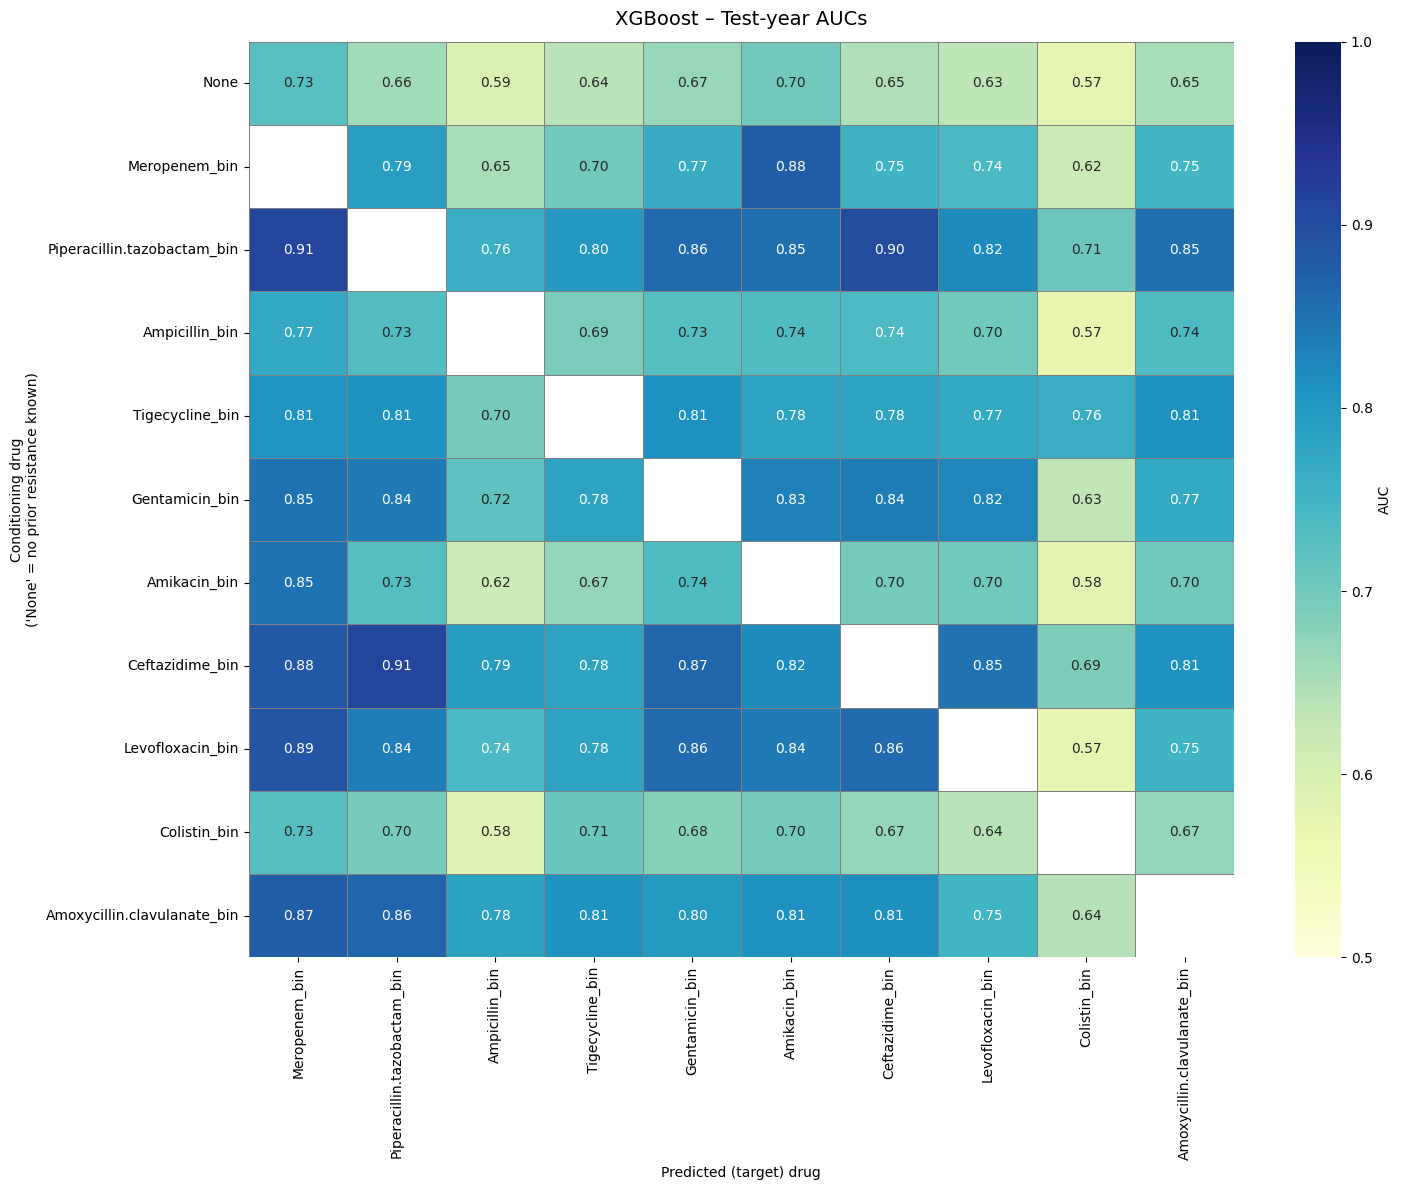

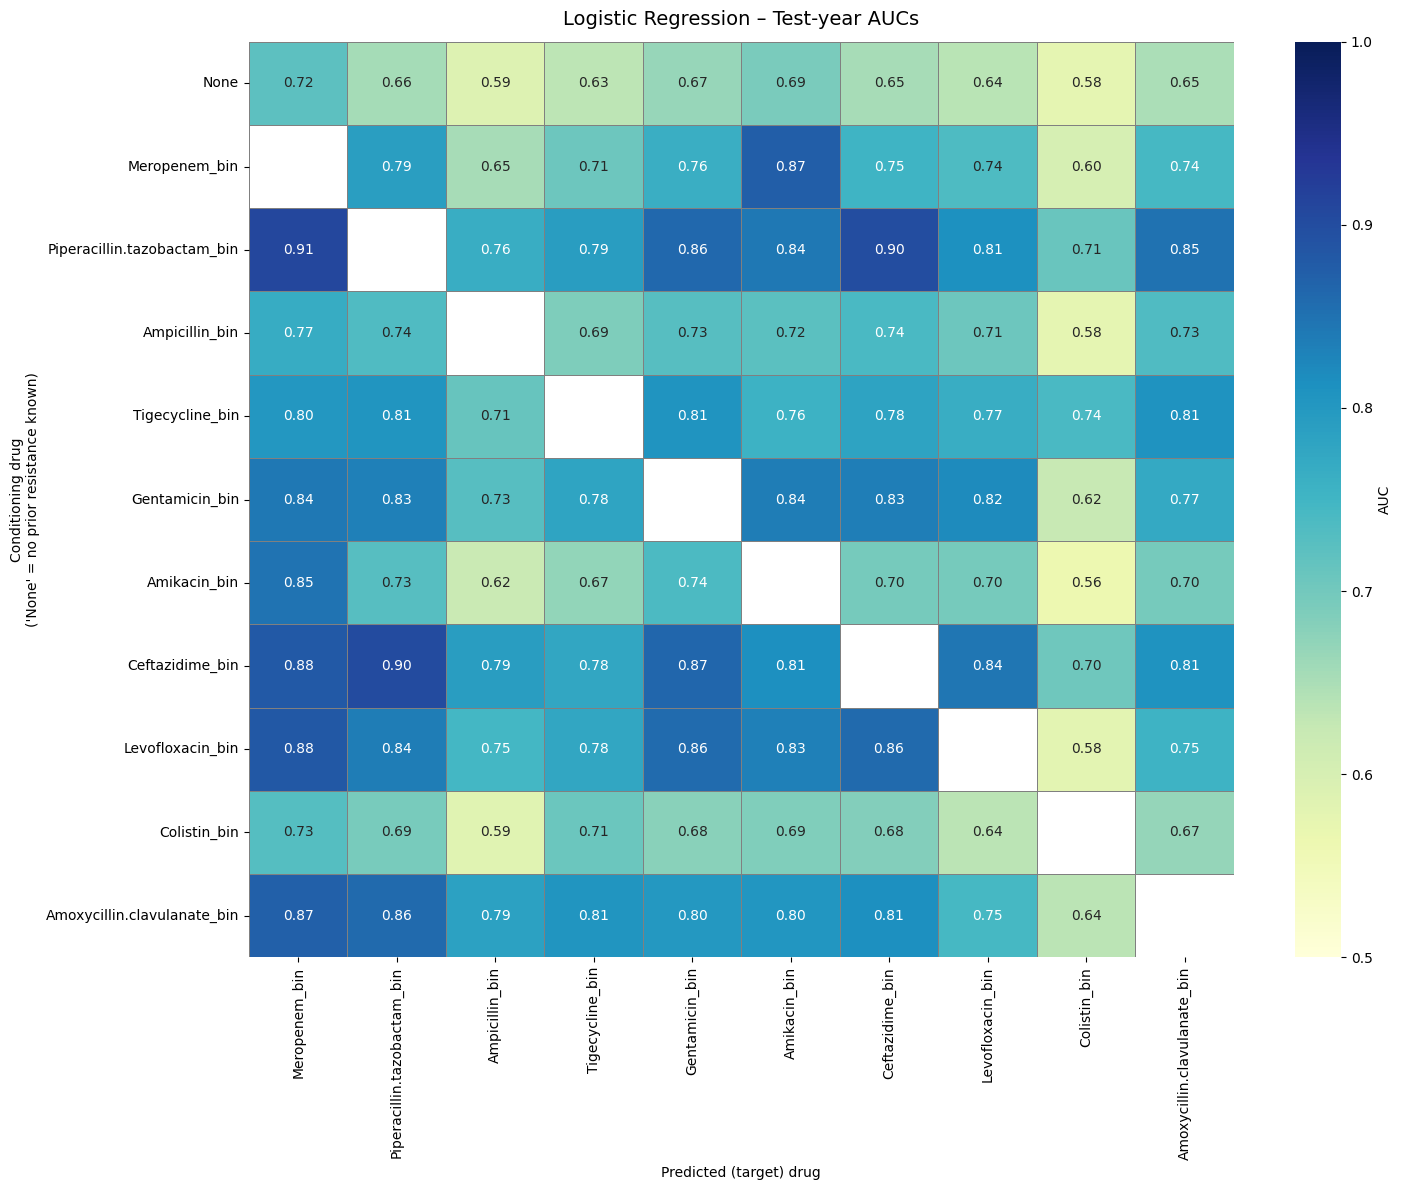

In [ ]:
##############################################################################
# 8.  Seaborn heat-map of AUCs (conditioning-drug × target-drug) #############
##############################################################################
import seaborn as sns
import matplotlib.pyplot as plt

def build_auc_matrix(roc_dict):
    """Return a DataFrame [conditioning]×[target] filled with AUC values."""
    cond_labels = ["None"] + drug_cols
    auc_mat = pd.DataFrame(index=cond_labels, columns=drug_cols, dtype=float)

    for cond in conditioning_choices:                 # None + 13 drugs
        row_name = "None" if cond is None else cond
        for tgt in roc_dict[cond].keys():             # targets available in this panel
            auc_val = roc_dict[cond][tgt][2]          # (fpr, tpr, AUC)
            auc_mat.loc[row_name, tgt] = auc_val
    return auc_mat

auc_xgb = build_auc_matrix(roc_store_xgb)
auc_lr  = build_auc_matrix(roc_store_lr)

# ---------------------------------------------------------------------------
# helper to plot one heat-map ------------------------------------------------
def plot_auc_heatmap(df, title, cmap="YlGnBu", vmin=0.5, vmax=1.0, save_as=None):
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        linewidths=0.5,
        linecolor="grey",
        cbar_kws={"label": "AUC"},
    )
    plt.title(title, fontsize=14, pad=12)
    plt.xlabel("Predicted (target) drug")
    plt.ylabel("Conditioning drug\n('None' = no prior resistance known)")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()

# ---------------------------------------------------------------------------
# 8-A.  Draw heat-maps for both models --------------------------------------
plot_auc_heatmap(auc_xgb, "XGBoost – Test-year AUCs", save_as="heatmap_auc_xgb.png")
plot_auc_heatmap(auc_lr,  "Logistic Regression – Test-year AUCs", save_as="heatmap_auc_lr.png")

## Heatmap for visualisation

In [ ]:
##############################################################################
# 9.  Heat-maps for Accuracy, Balanced-Accuracy, Precision, F1 ###############
##############################################################################
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    f1_score,
)
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 9-A.  Decide which scalar metrics you want
# ---------------------------------------------------------------------------
metrics_to_compute = {
    "ACC" : accuracy_score,
    "BACC": balanced_accuracy_score,
    "PREC": lambda y,t: precision_score(y, t, zero_division=0),
    "F1"  : lambda y,t: f1_score(y, t, zero_division=0),
}

# ---------------------------------------------------------------------------
# 9-B.  Helper: evaluate a fitted pipeline and return {target -> {metric: v}}
# ---------------------------------------------------------------------------
def evaluate_metrics(pipeline, cond_drug):
    """
    cond_drug: None or one of drug_cols
    returns dict[target][metric_name] = value
    """
    numeric = ["icu", "year"] + ([cond_drug] if cond_drug else [])
    targets = [d for d in drug_cols if d != cond_drug]
    
    X_test_cond = test_df[["gender", "age", "country"] + numeric]
    y_true      = test_df[targets]
    y_pred      = pd.DataFrame(
        pipeline.predict(X_test_cond), columns=targets, index=y_true.index
    )
    
    out = {}
    for tgt in targets:
        y_t = y_true[tgt].values
        y_p = y_pred[tgt].values
        if len(set(y_t)) < 2:             # metric undefined if only one class
            continue
        out[tgt] = {name: fn(y_t, y_p) for name, fn in metrics_to_compute.items()}
    return out

# ---------------------------------------------------------------------------
# 9-C.  Build metric stores in one pass (no retraining needed) --------------
#       – if you *still* have the fitted pipelines from section 7 in memory –
# ---------------------------------------------------------------------------
metric_store_xgb = {cd: evaluate_metrics(roc_store_xgb[cd]["__pipeline__"], cd)
                    for cd in conditioning_choices}

metric_store_lr  = {cd: evaluate_metrics(roc_store_lr[cd]["__pipeline__"],  cd)
                    for cd in conditioning_choices}

# If you did **not** keep the fitted pipelines inside roc_store_*,
# re-run train_and_curves() once more with a small tweak to return
# the pipeline object, or simply re-train here.

# ---------------------------------------------------------------------------
# 9-D.  Convert a store → DataFrames {metric_name: df}
# ---------------------------------------------------------------------------
def store_to_dfs(store):
    cond_labels = ["None"] + drug_cols
    dfs = {m: pd.DataFrame(index=cond_labels, columns=drug_cols, dtype=float)
           for m in metrics_to_compute.keys()}
    
    for cond, result in store.items():
        row = "None" if cond is None else cond
        for tgt, metdict in result.items():
            for m, v in metdict.items():
                dfs[m].loc[row, tgt] = v
    return dfs

dfs_xgb = store_to_dfs(metric_store_xgb)
dfs_lr  = store_to_dfs(metric_store_lr)

# ---------------------------------------------------------------------------
# 9-E.  Generic heat-map plotter
# ---------------------------------------------------------------------------
def plot_metric_heatmap(df, metric, model, cmap="YlGnBu", save_as=None):
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=0.0,
        vmax=1.0,
        linewidths=0.4,
        linecolor="grey",
        cbar_kws={"label": metric},
    )
    plt.title(f"{model} – {metric} (2023 test set)", fontsize=15, pad=12)
    plt.xlabel("Predicted (target) drug")
    plt.ylabel("Conditioning drug ('None' = no prior resistance known)")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=300, bbox_inches="tight")
    plt.show()

# ---------------------------------------------------------------------------
# 9-F.  Render every metric × model in a loop
# ---------------------------------------------------------------------------
for metric, cmap in zip(metrics_to_compute.keys(),
                        ["YlGnBu", "rocket_r", "PuBuGn", "OrRd"]):
    plot_metric_heatmap(dfs_xgb[metric], metric, "XGBoost", cmap,
                        save_as=f"heatmap_{metric.lower()}_xgb.png")
    plot_metric_heatmap(dfs_lr[metric],  metric, "LogReg", cmap,
                        save_as=f"heatmap_{metric.lower()}_lr.png")


KeyError: '__pipeline__'